In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy
from pylab import *
import scipy
from sklearn.decomposition import NMF
from seqnmf import seqnmf, plot, example_data
from scipy.interpolate import interp1d
from scipy.interpolate import pchip
from sklearn.metrics import r2_score
from scipy.spatial import distance
from scipy.integrate import simps
from skbio.stats.ordination import pcoa
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from scipy.spatial.distance import pdist
from skbio.stats.distance import permanova,anosim
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix
%run -i '../../utils.py'

# Get data

In [2]:
# read meta data
df_meta = pd.read_csv('../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta.rename({'MiceID':'SubjectID'}, axis=1)
df_meta.head()

,SubjectID,Vendor,Day,Diet,RandomizedGroup
SampleID,,,,,
sample131,BC1,Beijing,0,Control,C
sample132,BC2,Beijing,0,Control,B
sample133,BC3,Beijing,0,Control,A
sample134,BC4,Beijing,0,Control,D
sample135,BC5,Beijing,0,Control,E


In [3]:
# read SCFA data
df_scfa = pd.read_csv('../../our_data/SCFA.csv', index_col=0)
df_scfa.head()

,Acetate,Propionate,Butyrate,Total
SampleID,,,,
sample237,3.922274,0.996912,0.419991,5.477644
sample206,5.494682,2.134259,0.466907,8.627237
sample240,5.625903,1.033439,0.252562,7.048774
sample191,5.894712,2.738452,2.931885,12.272715
sample200,6.155865,2.885386,3.889499,13.293039


In [4]:
# bacteria
df_bac_relab_species = pd.read_csv('../../our_data/16S_relative_abundance_species.csv', index_col=0)
df_bac_absab_species = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df_bac_relab_genus = pd.read_csv('../../our_data/16S_relative_abundance_genus.csv', index_col=0)
df_bac_absab_genus = pd.read_csv('../../our_data/16S_absolute_abundance_genus.csv', index_col=0)
df_bac_relab_family = pd.read_csv('../../our_data/16S_relative_abundance_family.csv', index_col=0)
df_bac_absab_family = pd.read_csv('../../our_data/16S_absolute_abundance_family.csv', index_col=0)

# Quantify individualized response

In [8]:
def quantify_individualized_response(
    df_meta, # meta data
    df_var,  # variables to decompose
    diet,    # to which diet response was concerned
    method='seqNMF', # decomposition method, options include seqNMF, NMF, PCoA
                     # PCoA should not be used because it is not a factor analysis. We include it for control purposes.
    nc=2,    # number of components
    metric='minkowski', # distance metric
    center=True, # whether centralize control group
    plotfig=False, # whether plot figure
    savefig=False, # whether save figure
    xlim=None, # xaxis limit
    ylim=None,  # yaxis limit
    permutations=None # dict: some variables requires much higher permutation numbers
):
    if plotfig:
        fig,ax=plt.subplots(1,len(df_var.columns),figsize=(3*len(df_var.columns),3), squeeze=False)
    
    stats_summary = []
    for k,var_name in enumerate(df_var.columns):
        #print(var_name)
        
        # join meta data and variables
        # df_meta_var has dimension subject * time
        df_meta_var = pd.merge(deepcopy(df_meta), deepcopy(df_var[[var_name]]), left_index=True, right_index=True, how='inner')
        df_meta_var = df_meta_var[df_meta_var.Diet.isin([diet,'Control'])]
        df_meta_var = pd.pivot_table(df_meta_var, columns='Day', index='SubjectID', values=var_name)
        df_meta_var = df_meta_var.dropna(axis=1, how='all')

        # intrapolation for missing data
        for subject in df_meta_var.index:
            df_tmp = df_meta_var.loc[subject].dropna()
            x = list(df_tmp.index)
            y = list(df_tmp.values)
            if len(x)==1:
                # only single datapoint
                continue
            if len(x)>=2:
                f = InterpolatedUnivariateSpline(x, y, k=1)
                df_meta_var.loc[subject,:] = f(list(df_meta_var.columns))
        df_meta_var = df_meta_var.clip(lower=1e-100) # set negative values to zero
        assert df_meta_var.min().min()>=0
        assert np.all(df_meta_var.values >= 0)
        
        # normalize max to 1
        df_meta_var = df_meta_var/df_meta_var.max().max()
                
        # data decomposition
        if method=='NMF':
            model = NMF(n_components=nc, init='random', random_state=0, tol=1e-6, l1_ratio=1, alpha=0)
            W = model.fit_transform(df_meta_var.values)
            loadings = None
            df_W = pd.DataFrame(W, index=df_meta_var.index)
        if method=='seqNMF':
            np.random.seed(0)
            [W, H, cost, loadings, power] = seqnmf(df_meta_var.values, K=nc, L=1, Lambda=0, plot_it=False, shift=False, max_iter=1000)
            W=W[:,:,0]
            df_W = pd.DataFrame(W, index=df_meta_var.index)
        if method=='PCoA':
            dm = distance.squareform(distance.pdist(df_meta_var, metric=metric))
            df_dm = pd.DataFrame(dm, index = df_meta_var.index, columns = df_meta_var.index)
            OR = pcoa(df_dm.values, number_of_dimensions=nc)
            loadings = list(OR.proportion_explained)
            df_W = pd.DataFrame(OR.samples.values, index=df_meta_var.index)

        if len(df_W)==0 or df_W.isnull().values.any():
            continue
                    
        df_W = df_W.stack().to_frame().reset_index()
        df_W.columns = ['SubjectID','PC','Weights']
        df_W = pd.merge(df_W, df_meta[['SubjectID','Vendor','Diet']].drop_duplicates(), left_on='SubjectID', right_on='SubjectID', how='inner')
        df_W = pd.pivot_table(df_W, columns='PC', index=['SubjectID','Vendor','Diet'], values='Weights').reset_index()
        #print(df_W)
        
        # rank vendors
        df_W = df_W.sort_values(by='Vendor')
        all_vendors = list(set(df_W.Vendor))
        vendor_colors={'Beijing':'#1f77b4', 'Guangdong':'#ff7f0e', 'Hunan':'#2ca02c', 'Shanghai':'#d62728'}
    
        # centralize data by moving control gorup average to zero
        df_W_centered = deepcopy(df_W)
        if center:
            for vendor in all_vendors:
                # control
                df_W_ctr = df_W[(df_W.Vendor==vendor)&(df_W.Diet=='Control')]
                df_W_ctr_mean = df_W_ctr.mean()
                for PC in np.arange(0,nc):
                    df_W_centered.loc[(df_W_centered.Vendor==vendor)&(df_W_centered.Diet=='Control'),PC] = df_W_centered.loc[(df_W_centered.Vendor==vendor)&(df_W_centered.Diet=='Control'),PC]-df_W_ctr_mean[PC]
                    df_W_centered.loc[(df_W_centered.Vendor==vendor)&(df_W_centered.Diet==diet),PC] = df_W_centered.loc[(df_W_centered.Vendor==vendor)&(df_W_centered.Diet==diet),PC]-df_W_ctr_mean[PC]

        # test significant difference
        df_W_centered_diet = df_W_centered[df_W_centered.Diet==diet]
        dm = pdist(np.asarray(df_W_centered_diet[np.arange(0,nc)].values), metric=metric, w=loadings)
        DM = DistanceMatrix(dm,list(df_W_centered_diet.SubjectID))
        if permutations is not None and var_name in permutations.keys():
            stats = permanova(DM, grouping=list(df_W_centered_diet.Vendor), permutations=permutations[var_name])
        else:
            stats = permanova(DM, grouping=list(df_W_centered_diet.Vendor), permutations=9999)
        if stats['p-value'] == 0.0001:
            stats = permanova(DM, grouping=list(df_W_centered_diet.Vendor), permutations=99999)
        if stats['p-value'] == 0.00001:
            stats = permanova(DM, grouping=list(df_W_centered_diet.Vendor), permutations=999999)
        stats_summary.append([var_name, stats['test statistic'], stats['p-value']])
        
        # plot
        if plotfig:
            # keep the top2 components
            df_W_centered_top2 = df_W_centered.loc[:,['SubjectID','Vendor','Diet',0,1]]
            df_W_centered_top2.columns = ['SubjectID','Vendor','Diet','Factor_0','Factor_1']
            for vendor in all_vendors:
                # control
                df_W_centered_ctr = df_W_centered_top2[(df_W_centered_top2.Vendor==vendor)&(df_W_centered_top2.Diet=='Control')]
                var_ctr = df_W_centered_ctr[['Factor_0','Factor_1']].var()

                # diet
                df_W_centered_diet = df_W_centered_top2[(df_W_centered_top2.Vendor==vendor)&(df_W_centered_top2.Diet==diet)]
                var_diet = df_W_centered_diet[['Factor_0','Factor_1']].var()
                
                # plot eclipse
                if var_ctr.min()>1e-100 and var_diet.min()>1e-100:
                    mean_x_ctr, mean_y_ctr = confidence_ellipse(df_W_centered_ctr.Factor_0, df_W_centered_ctr.Factor_1, ax[0,k], edgecolor=None, facecolor=vendor_colors[vendor], alpha=0.3)
                    mean_x_diet, mean_y_diet = confidence_ellipse(df_W_centered_diet.Factor_0, df_W_centered_diet.Factor_1, ax[0,k], edgecolor=None, facecolor=vendor_colors[vendor], alpha=0.3)
                else:
                    mean_x_ctr  = np.mean(df_W_centered_ctr.Factor_0)
                    mean_y_ctr  = np.mean(df_W_centered_ctr.Factor_1)
                    mean_x_diet = np.mean(df_W_centered_diet.Factor_0)
                    mean_y_diet = np.mean(df_W_centered_diet.Factor_1)
                
                # plot an arrow pointing from control to diet
                ax[0,k].annotate(s='', xy=(mean_x_ctr,mean_y_ctr), xytext=(mean_x_diet,mean_y_diet), arrowprops=dict(arrowstyle='<-,head_length=1, head_width=1',color=vendor_colors[vendor], lw=3))

            _ = sns.scatterplot(x='Factor_0', y='Factor_1', hue='Vendor', style='Diet', s=100, data=df_W_centered_top2, ax=ax[0,k])
            _ = ax[0,k].set_title('%s, Statistic = %2.2f, p-value = %2.6f'%(var_name, stats['test statistic'], stats['p-value']))
            if loadings is not None:
                _ = ax[0,k].set_xlabel('Factor 0 (%2.2f)'%(loadings[0]*100))
                _ = ax[0,k].set_ylabel('Factor 1 (%2.2f)'%(loadings[1]*100))
            if xlim is not None:
                ax[0,k].set_xlim(xlim)
            if ylim is not None:
                ax[0,k].set_ylim(ylim)
            if center and xlim is not None and ylim is not None:
                ax[0,k].plot(xlim,[0,0],'k--')
                ax[0,k].plot([0,0],ylim,'k--')
    
    if plotfig:
        plt.tight_layout()
    
    # save figure
    if savefig:
        plt.rcParams['svg.fonttype'] = 'none'
        fig.savefig("individualized_response_%s.svg"%(diet), format="svg")

    df_stats = pd.DataFrame(stats_summary, columns=['Variable','Statistic','P-value'])
    df_stats['log10(P-value)'] = np.log10(df_stats['P-value'])
    if plotfig:
        return fig, df_stats
    else:
        return None, df_stats

# Inulin

## SCFA

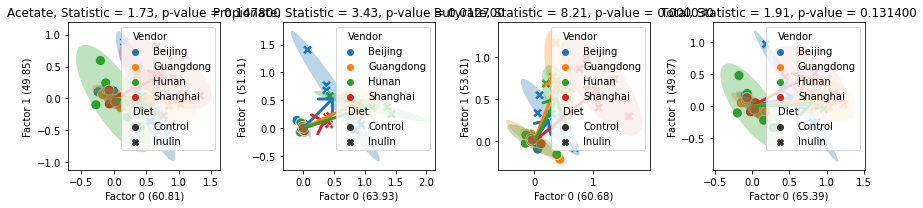

In [9]:
fig, df_stats_scfa = quantify_individualized_response(df_meta, df_scfa, diet='Inulin', plotfig=True, savefig=True)

### test effects of number of components

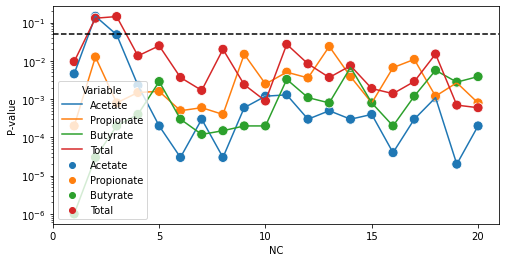

In [311]:
n_components=np.arange(1,21)
df_stats = None
for nc in n_components:
    _, dfss = quantify_individualized_response(df_meta, df_scfa, diet='Inulin', nc=nc)
    dfss['NC'] = nc
    if df_stats is None:
        df_stats = deepcopy(dfss)
    else:
        df_stats = pd.concat([df_stats, dfss], ignore_index=True)

fig,ax=plt.subplots(1,1,figsize=(8,4))
_  = sns.lineplot(x='NC', y='P-value', hue='Variable', data=df_stats, ax=ax)
_  = sns.scatterplot(x='NC', y='P-value', hue='Variable', data=df_stats, ax=ax, s=[100]*len(df_stats))
_ = ax.plot([0,21],[0.05,0.05],'k--')
_ = ax.set_yscale('log')
_ = ax.set_xlim([0,21])
_ = ax.set_xticks([0,5,10,15,20])
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("p_value_at_varied_component_number.svg", format="svg")

## Bacteria (relative abundance)

### species

In [312]:
_, df_stats_relab_species = quantify_individualized_response(
    df_meta, 
    df_bac_relab_species, 
    diet='Inulin', 
    plotfig=False
)
df_stats_relab_species.to_csv('bacterial_relative_abundance_stats_species.csv')
df_stats_relab_species.head()

,Variable,Statistic,P-value,log10(P-value)
0,A2,12.412505,0.00030,-3.522879
1,ASF356,17.545103,0.00008,-4.096910
2,Acetatifactor,89.470907,0.00020,-3.698970
3,Acetatifactor-muris,6.783040,0.00003,-4.522879
4,Acidovorax,0.842593,1.00000,0.000000


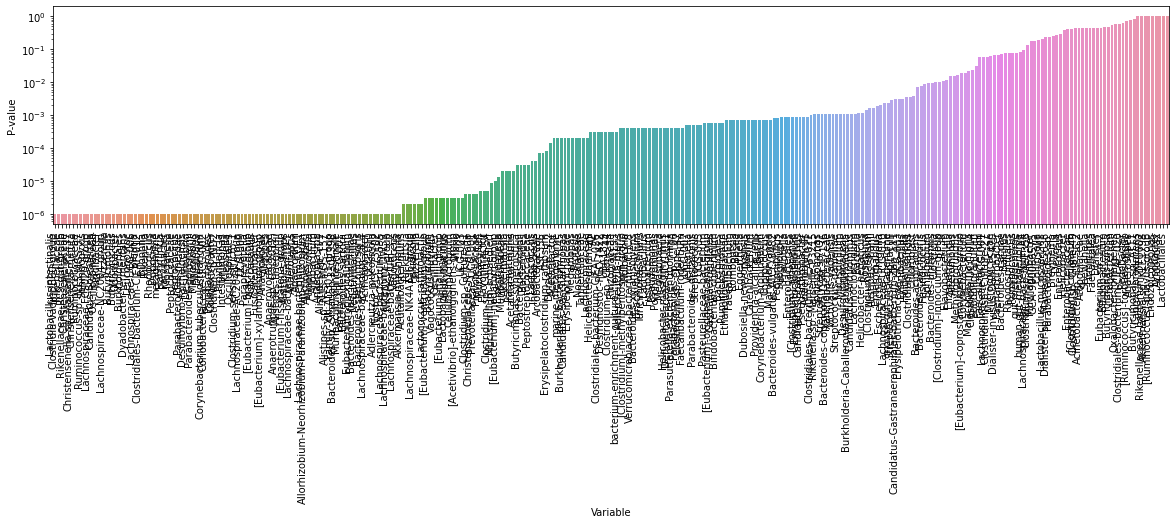

In [313]:
df_stats_relab_species = pd.read_csv('bacterial_relative_abundance_stats_species.csv', index_col=0)
fig,ax=plt.subplots(1,1,figsize=(20,4))
_ = sns.barplot(x='Variable', y='P-value', data=df_stats_relab_species.sort_values(by='P-value'), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
#_ = ax.plot([-1,25],[0.05,0.05],'k--')
#_ = ax.set_xlim([-1,22])
_ = ax.set_yscale('log')

### genus

In [211]:
selected_genus=['Bacteroides','Parabacteroides','Faecalibaculum','Parasutterella','Lachnospiraceae-NK4A136-group',
                'Muribaculaceae','Blautia','Akkermansia','Bacteroidales','Lachnospiraceae','Peptococcaceae',
                'Clostridia-vadinBB60-group','Alloprevotella','Escherichia-Shigella','Oscillospiraceae','Desulfovibrionaceae',
                'Helicobacter','Ruminococcus','Rikenellaceae-RC9-gut-group','Mucispirillum','Alistipes','Clostridia-UCG-014'
               ]
_, df_stats_relab_genus = quantify_individualized_response(
    df_meta, 
    df_bac_relab_genus[selected_genus], 
    diet='Inulin', 
    plotfig=False)
df_stats_relab_genus.to_csv('bacterial_relative_abundance_stats_genus.csv')
df_stats_relab_genus.head()

,Variable,Statistic,P-value,log10(P-value)
0,Bacteroides,2.782964,0.032700,-1.485452
1,Parabacteroides,35.364246,0.000001,-6.000000
2,Faecalibaculum,10.604609,0.000700,-3.154902
3,Parasutterella,7.852997,0.000030,-4.522879
4,Lachnospiraceae-NK4A136-group,22.472265,0.000030,-4.522879


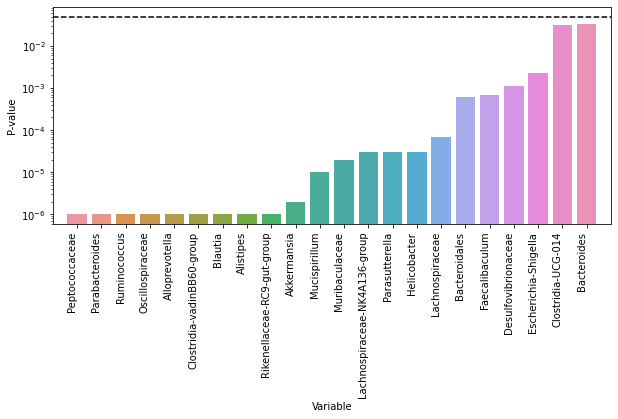

In [212]:
df_stats_relab_genus = pd.read_csv('bacterial_relative_abundance_stats_genus.csv', index_col=0)
fig,ax=plt.subplots(1,1,figsize=(10,4))
_ = sns.barplot(x='Variable', y='P-value', data=df_stats_relab_genus.sort_values(by='P-value'), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
_ = ax.plot([-1,25],[0.05,0.05],'k--')
_ = ax.set_xlim([-1,22])
_ = ax.set_yscale('log')

### family

In [213]:
selected_family=['Muribaculaceae','Erysipelotrichaceae','Sutterellaceae','Lachnospiraceae','Prevotellaceae',
                 'Oscillospiraceae','Bacteroidaceae','Desulfovibrionaceae','Akkermansiaceae','Tannerellaceae',
                 'Rikenellaceae','Helicobacteraceae','Ruminococcaceae','Clostridia-vadinBB60-group','Deferribacteraceae']

_, df_stats_relab_family = quantify_individualized_response(
    df_meta, 
    df_bac_relab_family[selected_family], 
    diet='Inulin', 
    plotfig=False
)
df_stats_relab_family.to_csv('bacterial_relative_abundance_stats_family.csv')
df_stats_relab_family.head()

,Variable,Statistic,P-value,log10(P-value)
0,Muribaculaceae,22.247185,0.0001,-4.00000
1,Erysipelotrichaceae,10.235474,0.0008,-3.09691
2,Sutterellaceae,7.852997,0.0001,-4.00000
3,Lachnospiraceae,14.029471,0.0001,-4.00000
4,Prevotellaceae,21.626272,0.0001,-4.00000


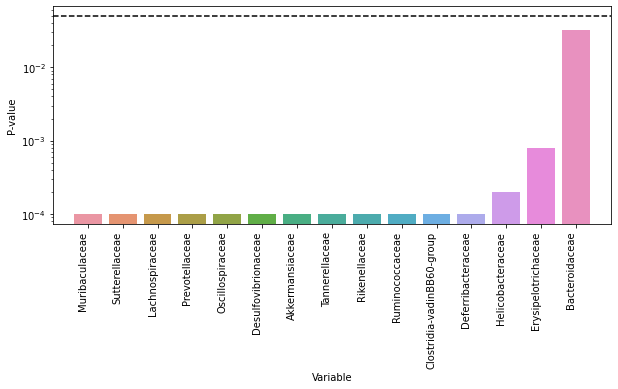

In [214]:
df_stats_relab_family = pd.read_csv('bacterial_relative_abundance_stats_family.csv', index_col=0)
fig,ax=plt.subplots(1,1,figsize=(10,4))
_ = sns.barplot(x='Variable', y='P-value', data=df_stats_relab_family.sort_values(by='P-value'), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
_ = ax.plot([-1,15],[0.05,0.05],'k--')
_ = ax.set_xlim([-1,15])
_ = ax.set_yscale('log')

##  Bacteria (absolute abundance)

### species

In [314]:
_, df_stats_absab_species = quantify_individualized_response(
    df_meta, 
    df_bac_absab_species, 
    diet='Inulin', 
    plotfig=False
)
df_stats_absab_species.to_csv('bacterial_absolute_abundance_stats_species.csv')
df_stats_absab_species.head()

,Variable,Statistic,P-value,log10(P-value)
0,A2,0.983041,0.4508,-0.346016
1,ASF356,1.756423,0.1444,-0.840433
2,Acetatifactor,3.278315,0.0151,-1.821023
3,Acetatifactor-muris,0.763920,0.8723,-0.059334
4,Acidovorax,0.842593,1.0000,0.000000


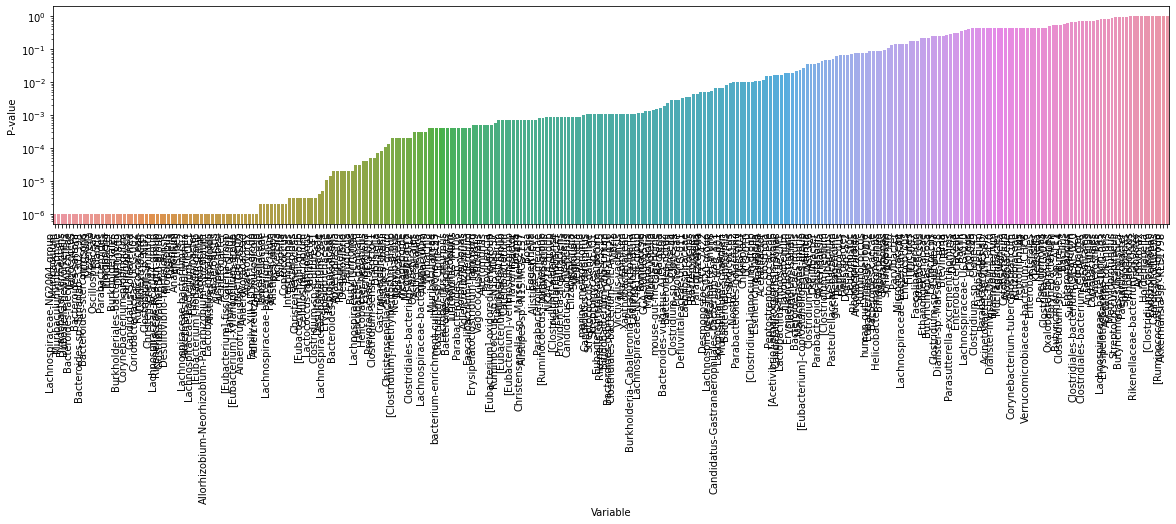

In [315]:
df_stats_absab_species = pd.read_csv('bacterial_absolute_abundance_stats_species.csv', index_col=0)
fig,ax=plt.subplots(1,1,figsize=(20,4))
_ = sns.barplot(x='Variable', y='P-value', data=df_stats_absab_species.sort_values(by='P-value'), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
#_ = ax.plot([-1,25],[0.05,0.05],'k--')
#_ = ax.set_xlim([-1,22])
_ = ax.set_yscale('log')

### genus

In [215]:
selected_genus=['Bacteroides','Parabacteroides','Faecalibaculum','Parasutterella','Lachnospiraceae-NK4A136-group',
                'Muribaculaceae','Blautia','Akkermansia','Bacteroidales','Lachnospiraceae','Peptococcaceae',
                'Clostridia-vadinBB60-group','Alloprevotella','Escherichia-Shigella','Oscillospiraceae','Desulfovibrionaceae',
                'Helicobacter','Ruminococcus','Rikenellaceae-RC9-gut-group','Mucispirillum','Alistipes','Clostridia-UCG-014'
               ]
_, df_stats_absab_genus = quantify_individualized_response(
    df_meta, 
    df_bac_absab_genus[selected_genus], 
    diet='Inulin', 
    plotfig=False
)
df_stats_absab_genus.to_csv('bacterial_absolute_abundance_stats_genus.csv')
df_stats_absab_genus.head()

,Variable,Statistic,P-value,log10(P-value)
0,Bacteroides,11.834389,0.0001,-4.000000
1,Parabacteroides,5.326835,0.0018,-2.744727
2,Faecalibaculum,11.993906,0.0001,-4.000000
3,Parasutterella,9.358574,0.0001,-4.000000
4,Lachnospiraceae-NK4A136-group,3.236266,0.0010,-3.000000


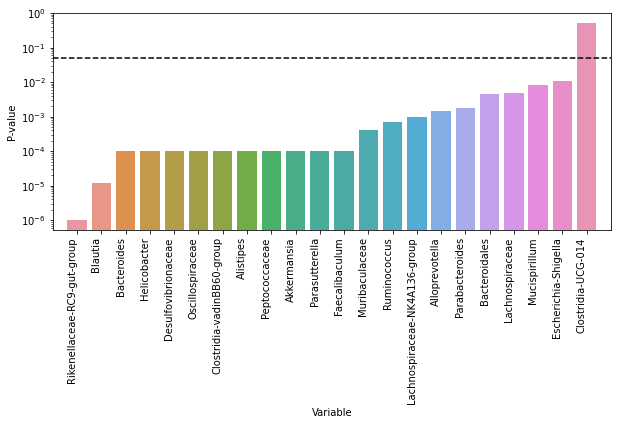

In [216]:
df_stats_absab_genus = pd.read_csv('bacterial_absolute_abundance_stats_genus.csv', index_col=0)
fig,ax=plt.subplots(1,1,figsize=(10,4))
_ = sns.barplot(x='Variable', y='P-value', data=df_stats_absab_genus.sort_values(by='P-value'), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
_ = ax.plot([-1,25],[0.05,0.05],'k--')
_ = ax.set_xlim([-1,22])
_ = ax.set_yscale('log')

### family

In [217]:
selected_family=['Muribaculaceae','Erysipelotrichaceae','Sutterellaceae','Lachnospiraceae','Prevotellaceae',
                 'Oscillospiraceae','Bacteroidaceae','Desulfovibrionaceae','Akkermansiaceae','Tannerellaceae',
                 'Rikenellaceae','Helicobacteraceae','Ruminococcaceae','Clostridia-vadinBB60-group','Deferribacteraceae']

_, df_stats_absab_family = quantify_individualized_response(
    df_meta, 
    df_bac_absab_family[selected_family], 
    diet='Inulin', 
    plotfig=False
)
df_stats_absab_family.to_csv('bacterial_absolute_abundance_stats_family.csv')
df_stats_absab_family.head()

,Variable,Statistic,P-value,log10(P-value)
0,Muribaculaceae,10.843477,0.0004,-3.397940
1,Erysipelotrichaceae,10.165272,0.0001,-4.000000
2,Sutterellaceae,9.358574,0.0001,-4.000000
3,Lachnospiraceae,7.177188,0.0055,-2.259637
4,Prevotellaceae,6.997958,0.0014,-2.853872


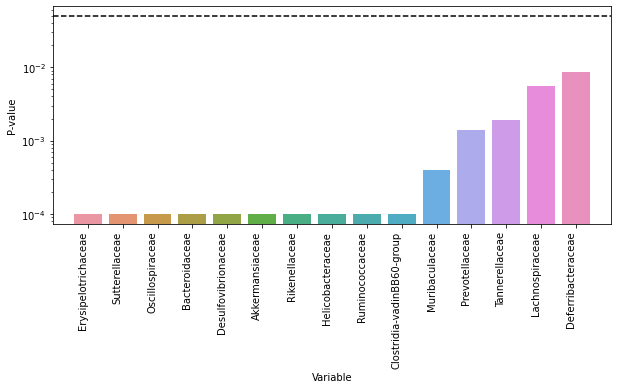

In [218]:
df_stats_absab_family = pd.read_csv('bacterial_absolute_abundance_stats_family.csv', index_col=0)
fig,ax=plt.subplots(1,1,figsize=(10,4))
_ = sns.barplot(x='Variable', y='P-value', data=df_stats_absab_family.sort_values(by='P-value'), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
_ = ax.plot([-1,15],[0.05,0.05],'k--')
_ = ax.set_xlim([-1,15])
_ = ax.set_yscale('log')

## Compare P-value at relative abundance and absolute abundance

### species

In [14]:
# read relative abundance
df_stats_relab_species = pd.read_csv('bacterial_relative_abundance_stats_species.csv', index_col=0)
df_stats_relab_species = df_stats_relab_species[['Variable','log10(P-value)']]
df_stats_relab_species.columns = ['Variable','logP_relab']

# read absolute abundance
df_stats_absab_species = pd.read_csv('bacterial_absolute_abundance_stats_species.csv', index_col=0)
df_stats_absab_species = df_stats_absab_species[['Variable','log10(P-value)']]
df_stats_absab_species.columns = ['Variable','logP_absab']

# join two tables
df_joint = pd.merge(df_stats_relab_species,df_stats_absab_species, left_on='Variable', right_on='Variable', how='inner')

# calculate area ratio of absolute abundance
df_meta_inulin = df_meta[df_meta.Diet=='Inulin']
df_meta_control = df_meta[df_meta.Diet=='Control']
lines = []
for var_name in df_stats_absab_species.Variable:
    # max relative abundance in inulin group
    max_relab = np.max(df_bac_relab_species.loc[df_meta_inulin.index,var_name])
    
    # averaged relative abundance in inulin group
    mean_relab = np.mean(df_bac_relab_species.loc[df_meta_inulin.index,var_name])
    
    # max absolute abundance in inulin group
    max_absab = np.log10(np.max(df_bac_absab_species.loc[df_meta_inulin.index,var_name]))
    
    # averaged absolute abundance in inulin group
    mean_absab = np.log10(np.mean(df_bac_absab_species.loc[df_meta_inulin.index,var_name]))
    
    # area of absolute abundance for inulin mice
    area_inulin = 0
    all_subjects_inulin = list(set(df_meta_inulin.SubjectID))
    for subject in all_subjects_inulin:
        df_tmp = df_meta_inulin[df_meta_inulin.SubjectID==subject].sort_values(by='Day')
        x = list(df_tmp.Day)
        y = list(df_bac_absab_species.loc[df_tmp.index,var_name])
        f = InterpolatedUnivariateSpline(x, y, k=1)
        xs = np.arange(0,32)
        ys = f(xs)
        area_inulin += simps(ys,xs)
    area_inulin /= len(all_subjects_inulin)

    # area of absolute abundance for cellulose mice
    area_control = 0
    all_subjects_control = list(set(df_meta_control.SubjectID))
    for subject in all_subjects_control:
        df_tmp = df_meta_control[df_meta_control.SubjectID==subject].sort_values(by='Day')
        x = list(df_tmp.Day)
        y = list(df_bac_absab_species.loc[df_tmp.index,var_name])
        f = InterpolatedUnivariateSpline(x, y, k=1)
        xs = np.arange(0,32)
        ys = f(xs)
        area_control += simps(ys,xs)
    area_control /= len(all_subjects_control)
    
    # area ratio
    if area_inulin>0.0 or area_control>0.0:
        lines.append([var_name, 
                      max_relab, 
                      mean_relab, 
                      max_absab,
                      mean_absab,
                      np.abs(area_inulin-area_control)/(area_inulin+area_control) # Bray-curtis distance
                     ])
df_lines = pd.DataFrame(lines, columns=['Variable','MaxRelab','MeanRelab','MaxAbsab','MeanAbsab','BrayCurtis'])
df_joint = pd.merge(df_joint, df_lines, left_on='Variable', right_on='Variable', how='inner')
df_joint

,Variable,logP_relab,logP_absab,MaxRelab,MeanRelab,MaxAbsab,MeanAbsab,BrayCurtis
0,A2,-3.522879,-0.346016,0.007363,3.689788e-04,6.450182,4.965233,0.029997
1,ASF356,-4.096910,-0.840433,0.004105,4.988350e-04,6.334675,5.170320,0.164756
2,Acetatifactor,-3.698970,-1.821023,0.007949,5.697386e-04,6.569036,5.174236,0.101640
3,Acetatifactor-muris,-4.522879,-0.059334,0.000050,2.063853e-06,4.270934,2.757034,0.425533
4,Acidovorax,0.000000,0.000000,0.000042,2.688223e-07,3.563381,1.367482,1.000000
...,...,...,...,...,...,...,...,...
293,gut-metagenome,-1.076756,-1.177178,0.007318,5.824554e-04,6.478550,5.189902,0.426065
294,human-gut-metagenome,-1.034328,-1.061480,0.000036,3.918265e-07,4.061646,2.033345,0.240536
295,marine-metagenome,-3.698970,-2.958607,0.000061,1.716284e-06,4.167344,2.480476,0.156255
296,metagenome,-6.000000,-3.698970,0.000050,6.534389e-07,4.355489,2.416133,0.431132


In [80]:
# percentage of insignificant bacteria
len(df_joint[df_joint.logP_absab<=np.log10(0.05)])/len(df_joint)

0.6912751677852349

In [79]:
# percentage of bacteria with p value<=1e-6
len(df_joint[df_joint.logP_absab==-6])/len(df_joint)

0.16778523489932887

5.838358954277255 -6.0
5.776195969832206 -0.14849704722945534
6.868067779389533 -0.27761290582287634
7.3453837304301075 -6.0


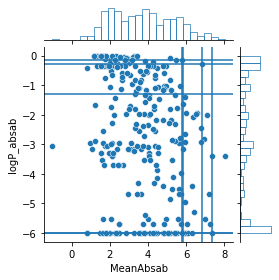

In [78]:
ax = sns.jointplot(x='MeanAbsab', 
                  y='logP_absab', 
                  data = df_joint[np.isfinite(df_joint.MeanAbsab)], 
                  kind='scatter',
                  dropna=True,
                  height=4,
                  marginal_kws=dict(bins=25, fill=False)
                 )
ax.ax_joint.axhline(y=np.log10(0.05))

for species in ['Parabacteroides','Anaerotruncus','Clostridia-UCG-014','Akkermansia-muciniphila']:
    xcorr = list(df_joint.loc[df_joint.Variable==species,'MeanAbsab'])[0]
    ycorr = list(df_joint.loc[df_joint.Variable==species,'logP_absab'])[0]
    print(xcorr,ycorr)
    ax.ax_joint.axhline(ycorr)
    ax.ax_joint.axvline(xcorr)
plt.rcParams['svg.fonttype'] = 'none'
ax.savefig("p_value_scatterplot.svg", format="svg")

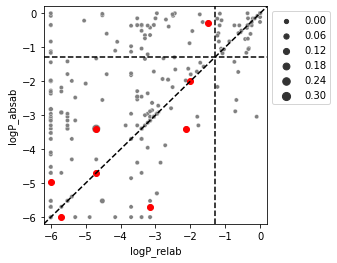

In [46]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
_ = sns.scatterplot(x='logP_relab', y='logP_absab', size='MeanRelab', data=df_joint, color='gray')

df_joint_sorted = df_joint[df_joint.BrayCurtis>=0.5].sort_values('MeanRelab', ascending=False)
for i in np.arange(0,8):
    ax.plot(df_joint_sorted.iloc[i]['logP_relab'],df_joint_sorted.iloc[i]['logP_absab'],'ro')

_ = ax.plot([-6.2,0.2],[-6.2,0.2],'k--')
_ = ax.plot([-6.2,0.2],[np.log10(0.05),np.log10(0.05)], 'k--')
_ = ax.plot([np.log10(0.05),np.log10(0.05)], [-6.2,0.2], 'k--')
_ = ax.legend(bbox_to_anchor=(1.0,1.0))
_ = ax.set_xlim([-6.2,0.2])
_ = ax.set_ylim([-6.2,0.2])
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("p_value_scatterplot.svg", format="svg")

In [61]:
df_joint[(df_joint.MeanAbsab>6)].sort_values('logP_absab', ascending=True).head(10)

,Variable,logP_relab,logP_absab,MaxRelab,MeanRelab,MaxAbsab,MeanAbsab,BrayCurtis
11,Akkermansia-muciniphila,-5.698970,-6.000000,0.319296,0.066252,8.195382,7.345384,0.852634
203,Oscillospiraceae,-6.000000,-6.000000,0.113453,0.008035,7.647198,6.298172,0.163200
195,Muribaculum,-5.301030,-6.000000,0.081589,0.004098,7.387710,6.111626,0.812390
98,Colidextribacter,-6.000000,-6.000000,0.042955,0.003818,7.235089,6.002277,0.148794
167,Lachnospiraceae-bacterium-10-1,-6.000000,-5.698970,0.277841,0.003117,8.098185,6.060448,0.347455
137,Faecalibaculum,-3.154902,-5.698970,0.305266,0.076283,7.947732,7.278777,0.629095
39,Bacteroides,-4.522879,-5.522879,0.437141,0.067033,7.765578,6.992080,0.384772
110,Desulfovibrionaceae,-2.958607,-5.301030,0.211932,0.011305,7.532702,6.435378,0.478901
215,Parasutterella,-4.698970,-4.698970,0.278650,0.069478,7.839953,7.191542,0.783557
152,Helicobacter-ganmani,-3.522879,-4.397940,0.151487,0.007856,7.517038,6.307338,0.203441


In [59]:
df_joint[df_joint.Variable=='Parabacteroides']

,Variable,logP_relab,logP_absab,MaxRelab,MeanRelab,MaxAbsab,MeanAbsab,BrayCurtis
208,Parabacteroides,-6.0,-6.0,0.04718,0.002732,7.044038,5.838359,0.59102


### genus

In [219]:
# read relative abundance
df_stats_relab_genus = pd.read_csv('bacterial_relative_abundance_stats_genus.csv', index_col=0)
df_stats_relab_genus = df_stats_relab_genus[['Variable','log10(P-value)']]
df_stats_relab_genus.columns = ['Variable','logP_relab']

# read absolute abundance
df_stats_absab_genus = pd.read_csv('bacterial_absolute_abundance_stats_genus.csv', index_col=0)
df_stats_absab_genus = df_stats_absab_genus[['Variable','log10(P-value)']]
df_stats_absab_genus.columns = ['Variable','logP_absab']

# join two tables
df_joint = pd.merge(df_stats_relab_genus,df_stats_absab_genus, left_on='Variable', right_on='Variable', how='inner')

# calculate area ratio of absolute abundance
df_meta_inulin = df_meta[df_meta.Diet=='Inulin']
df_meta_control = df_meta[df_meta.Diet=='Control']
lines = []
for var_name in df_stats_absab_genus.Variable:
    # inulin
    area_inulin = 0
    all_subjects_inulin = list(set(df_meta_inulin.SubjectID))
    for subject in all_subjects_inulin:
        df_tmp = df_meta_inulin[df_meta_inulin.SubjectID==subject].sort_values(by='Day')
        x = list(df_tmp.Day)
        y = list(df_bac_absab_genus.loc[df_tmp.index,var_name])
        f = InterpolatedUnivariateSpline(x, y, k=1)
        xs = np.arange(0,32)
        ys = f(xs)
        area_inulin += simps(ys,xs)
    area_inulin /= len(all_subjects_inulin)

    # control
    area_control = 0
    all_subjects_control = list(set(df_meta_control.SubjectID))
    for subject in all_subjects_control:
        df_tmp = df_meta_control[df_meta_control.SubjectID==subject].sort_values(by='Day')
        x = list(df_tmp.Day)
        y = list(df_bac_absab_genus.loc[df_tmp.index,var_name])
        f = InterpolatedUnivariateSpline(x, y, k=1)
        xs = np.arange(0,32)
        ys = f(xs)
        area_control += simps(ys,xs)
    area_control /= len(all_subjects_control)
    
    # area ratio
    lines.append([var_name, area_inulin/area_control])
df_lines = pd.DataFrame(lines, columns=['Variable','AreaRatio'])
df_lines['AreaRatio'] = df_lines['AreaRatio']/np.max(df_lines['AreaRatio'])
df_joint = pd.merge(df_joint, df_lines, left_on='Variable', right_on='Variable', how='inner').sort_values('AreaRatio',ascending=False)
df_joint

,Variable,logP_relab,logP_absab,AreaRatio
21,Clostridia-UCG-014,-1.497573,-0.277613,1.000000
8,Bacteroidales,-3.221849,-2.356547,0.820073
7,Akkermansia,-5.698970,-4.000000,0.716691
3,Parasutterella,-4.522879,-4.000000,0.455099
5,Muribaculaceae,-4.698970,-3.397940,0.433172
17,Ruminococcus,-6.000000,-3.154902,0.422865
2,Faecalibaculum,-3.154902,-4.000000,0.250780
0,Bacteroides,-1.485452,-4.000000,0.230568
13,Escherichia-Shigella,-2.638272,-1.954677,0.132903
4,Lachnospiraceae-NK4A136-group,-4.522879,-3.000000,0.130727


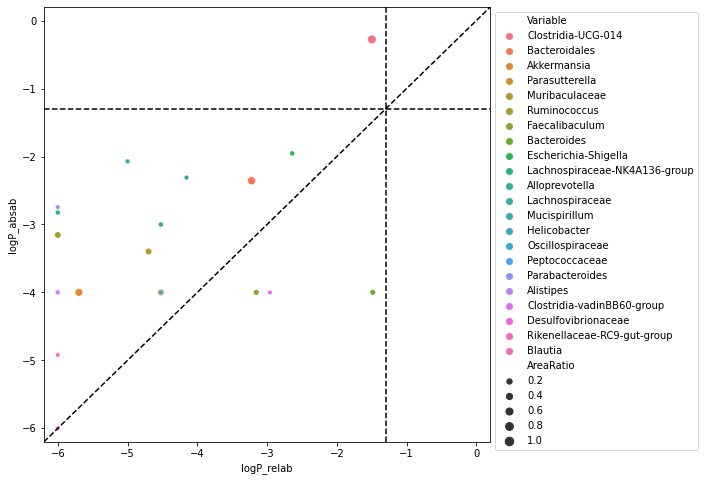

In [230]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
_ = sns.scatterplot(x='logP_relab', y='logP_absab', hue='Variable', size='AreaRatio', data=df_joint, color='gray')
_ = ax.plot([-6.2,0.2],[-6.2,0.2],'k--')
_ = ax.plot([-6.2,0.2],[np.log10(0.05),np.log10(0.05)], 'k--')
_ = ax.plot([np.log10(0.05),np.log10(0.05)], [-6.2,0.2], 'k--')
_ = ax.legend(bbox_to_anchor=(1.0,1.0))
_ = ax.set_xlim([-6.2,0.2])
_ = ax.set_ylim([-6.2,0.2])

## Plot representative bacteria

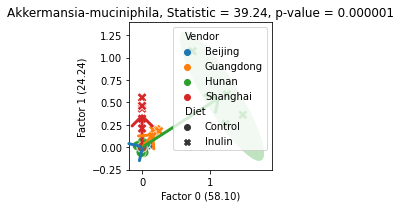

In [81]:
fig, df_stats_bac = quantify_individualized_response(
    df_meta, 
    df_bac_absab_species[['Akkermansia-muciniphila']], 
    diet='Inulin', 
    plotfig=True,
    savefig=True
)

In [ ]:
fig, df_stats_bac = quantify_individualized_response(
    df_meta, 
    df_bac_absab_species[['Muribaculaceae','Bacteroides-acidifaciens','Clostridia-UCG-014','Anaerotruncus']], 
    diet='Inulin', 
    plotfig=True,
    savefig=True
)